In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
import os
from scipy.ndimage import gaussian_filter, median_filter
from scipy.signal import wiener
from sklearn.cluster import KMeans
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, assemble
from qiskit import Aer
from qiskit.circuit.library import MCXGate

1. Preprocessing image...
   Detected noise level: 0.0031
2. Creating patches...
3. Quantum processing patches...
   Processing patch 0/256
   Processing patch 50/256
   Processing patch 100/256
   Processing patch 150/256
   Processing patch 200/256
   Processing patch 250/256
4. Decoding quantum features...
5. Applying adaptive classical denoising...


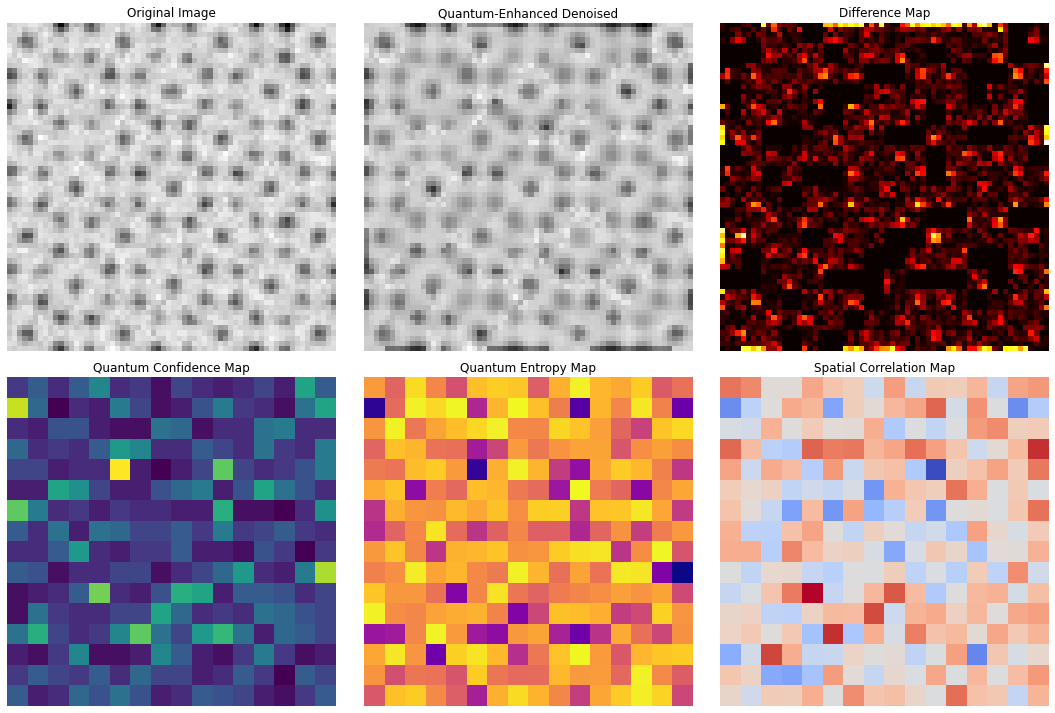


Denoising Performance Metrics:
SNR Improvement: 6.51 dB
Edge Preservation: 0.828
Mean Quantum Confidence: 0.008
Mean Quantum Entropy: 9.533


In [2]:
class QuantumMicroscopyDenoiser:
    def __init__(self, patch_size=4, threshold=0.5):
        self.patch_size = patch_size
        self.threshold = threshold
        self.quantum_features = {}
        self.confidence_map = None
        
    def preprocess_image(self, image_path, size=(64,64)):
        """Enhanced preprocessing with noise characterization"""
        img = Image.open(image_path).convert('L')
        img_resized = img.resize(size)
        img_array = np.array(img_resized) / 255.0
        
        # Estimate noise level
        noise_level = self.estimate_noise_level(img_array)
        return img_array, noise_level
    
    def estimate_noise_level(self, img_array):
        """Estimate noise level using Laplacian variance"""
        laplacian_var = np.var(gaussian_filter(img_array, sigma=1) - img_array)
        return laplacian_var
    
    def create_oracle(self, img_array, threshold=None):
        """Enhanced oracle with adaptive thresholding"""
        if threshold is None:
            threshold = self.threshold
            
        size = img_array.shape[0]
        n_qubits = size * size
        oracle_qc = QuantumCircuit(n_qubits)
        
        # Adaptive threshold based on local statistics
        local_mean = np.mean(img_array)
        local_std = np.std(img_array)
        adaptive_threshold = local_mean + 0.5 * local_std
        
        for i, pixel in enumerate(img_array.flatten()):
            if pixel < adaptive_threshold:
                oracle_qc.x(i)
        
        mcx = MCXGate(n_qubits - 1)
        oracle_qc.append(mcx, list(range(n_qubits)))
        
        return oracle_qc.to_gate(label='Oracle')
    
    def diffusion_operator(self, n_qubits):
        """Diffusion operator for Grover's algorithm"""
        qc = QuantumCircuit(n_qubits)
        
        for qubit in range(n_qubits):
            qc.h(qubit)
        
        for qubit in range(n_qubits):
            qc.x(qubit)
        
        mcx = MCXGate(n_qubits - 1)
        qc.append(mcx, list(range(n_qubits)))
        
        for qubit in range(n_qubits):
            qc.x(qubit)
        
        for qubit in range(n_qubits):
            qc.h(qubit)
        
        return qc.to_gate(label='Diffusion')
    
    def apply_grovers_search(self, qc, oracle, n_iterations=1):
        """Apply Grover's search algorithm"""
        n_qubits = qc.num_qubits
        diffusion = self.diffusion_operator(n_qubits)
        
        for _ in range(n_iterations):
            qc.append(oracle, list(range(n_qubits)))
            qc.append(diffusion, list(range(n_qubits)))
    
    def quantum_segment_patch(self, img_array, n_iterations=1):
        """Enhanced quantum segmentation with feature extraction"""
        size = img_array.shape[0]
        n_qubits = size * size
        
        qr = QuantumRegister(n_qubits, 'q')
        cr = ClassicalRegister(n_qubits, 'c')
        qc = QuantumCircuit(qr, cr)
        
        # Enhanced state preparation with amplitude encoding
        flat_img = img_array.flatten()
        for i, pixel in enumerate(flat_img):
            if pixel > 0:
                # Use RY rotation for amplitude encoding
                qc.ry(2 * np.arccos(np.sqrt(min(pixel, 0.999))), qr[i])
        
        # Apply quantum feature extraction
        oracle = self.create_oracle(img_array)
        self.apply_grovers_search(qc, oracle, n_iterations)
        
        # Add quantum Fourier transform for frequency analysis
        self.apply_qft_analysis(qc, qr)
        
        qc.measure(qr, cr)
        
        # Simulate
        simulator = Aer.get_backend('qasm_simulator')
        compiled = transpile(qc, simulator)
        result = simulator.run(assemble(compiled, shots=1024)).result()
        counts = result.get_counts()
        
        return self.extract_quantum_features(counts, size, img_array)
    
    def apply_qft_analysis(self, qc, qr):
        """Apply simplified QFT for frequency domain analysis"""
        n_qubits = len(qr)
        # Simplified QFT implementation for small patches
        for i in range(min(n_qubits, 4)):  # Limit QFT to prevent circuit depth issues
            qc.h(qr[i])
            for j in range(i+1, min(n_qubits, 4)):
                qc.cp(np.pi/2**(j-i), qr[j], qr[i])
    
    def extract_quantum_features(self, counts, size, original_patch):
        """Extract meaningful features from quantum measurements"""
        features = {}
        
        # 1. Probability distribution analysis
        total_shots = sum(counts.values())
        prob_dist = {k: v/total_shots for k, v in counts.items()}
        
        # 2. Entropy calculation (measure of quantum coherence)
        entropy = -sum(p * np.log2(p + 1e-10) for p in prob_dist.values())
        features['entropy'] = entropy
        
        # 3. Most probable states (potential feature pixels)
        sorted_states = sorted(counts.items(), key=lambda x: x[1], reverse=True)
        features['top_states'] = sorted_states[:5]
        
        # 4. Confidence based on measurement concentration
        max_count = max(counts.values())
        confidence = max_count / total_shots
        features['confidence'] = confidence
        
        # 5. Spatial correlation with original patch
        features['spatial_correlation'] = self.calculate_spatial_correlation(
            sorted_states, size, original_patch
        )
        
        return features
    
    def calculate_spatial_correlation(self, sorted_states, size, original_patch):
        """Calculate spatial correlation between quantum measurements and original patch"""
        correlations = []
        
        for bitstring, count in sorted_states[:3]:  # Top 3 states
            # Convert bitstring to spatial pattern
            pattern = np.zeros((size, size))
            bitstring_clean = bitstring.replace(' ', '')
            
            if len(bitstring_clean) == size * size:
                for i, bit in enumerate(bitstring_clean):
                    if bit == '1':
                        row, col = i // size, i % size
                        pattern[row, col] = 1
                
                # Calculate correlation with original patch
                correlation = np.corrcoef(pattern.flatten(), original_patch.flatten())[0, 1]
                if not np.isnan(correlation):
                    correlations.append(correlation * count)
        
        return np.mean(correlations) if correlations else 0
    
    def decode_quantum_features(self, all_quantum_features, original_shape):
        """Decode quantum features back to spatial domain"""
        h, w = original_shape
        patch_h, patch_w = self.patch_size, self.patch_size
        
        # Initialize decoded features maps
        confidence_map = np.zeros((h, w))
        entropy_map = np.zeros((h, w))
        correlation_map = np.zeros((h, w))
        
        patch_idx = 0
        for i in range(0, h, patch_h):
            for j in range(0, w, patch_w):
                if patch_idx < len(all_quantum_features):
                    features = all_quantum_features[patch_idx]
                    
                    # Map features back to spatial coordinates
                    end_i = min(i + patch_h, h)
                    end_j = min(j + patch_w, w)
                    
                    confidence_map[i:end_i, j:end_j] = features.get('confidence', 0)
                    entropy_map[i:end_i, j:end_j] = features.get('entropy', 0)
                    correlation_map[i:end_i, j:end_j] = features.get('spatial_correlation', 0)
                
                patch_idx += 1
        
        return {
            'confidence': confidence_map,
            'entropy': entropy_map,
            'correlation': correlation_map
        }
    
    def adaptive_classical_denoising(self, img_array, feature_maps):
        """Apply classical denoising guided by quantum features"""
        confidence_map = feature_maps['confidence']
        entropy_map = feature_maps['entropy']
        
        # Create adaptive filter weights based on quantum confidence
        denoised = np.copy(img_array)
        
        # High confidence regions: preserve original
        high_conf_mask = confidence_map > np.percentile(confidence_map, 75)
        
        # Low confidence regions: apply stronger denoising
        low_conf_mask = confidence_map < np.percentile(confidence_map, 25)
        
        # Medium confidence: apply moderate denoising
        med_conf_mask = ~(high_conf_mask | low_conf_mask)
        
        # Apply different denoising strategies
        # Gaussian filter for low confidence (noisy) regions
        denoised_gaussian = gaussian_filter(img_array, sigma=1.5)
        denoised[low_conf_mask] = denoised_gaussian[low_conf_mask]
        
        # Median filter for medium confidence regions
        denoised_median = median_filter(img_array, size=3)
        denoised[med_conf_mask] = 0.7 * denoised_median[med_conf_mask] + 0.3 * img_array[med_conf_mask]
        
        # Wiener filter for edge enhancement where appropriate
        entropy_threshold = np.percentile(entropy_map, 60)
        edge_regions = entropy_map > entropy_threshold
        
        if np.any(edge_regions):
            # Apply edge-preserving filter
            denoised_wiener = wiener(img_array, noise=0.1)
            denoised[edge_regions] = denoised_wiener[edge_regions]
        
        return denoised
    
    def process_image(self, image_path):
        """Complete quantum-classical denoising pipeline"""
        print("1. Preprocessing image...")
        img_array, noise_level = self.preprocess_image(image_path)
        original_shape = img_array.shape
        
        print(f"   Detected noise level: {noise_level:.4f}")
        
        print("2. Creating patches...")
        patches = self.create_patches(img_array)
        
        print("3. Quantum processing patches...")
        all_quantum_features = []
        
        for i, patch in enumerate(patches):
            if i % 50 == 0:
                print(f"   Processing patch {i}/{len(patches)}")
            
            features = self.quantum_segment_patch(patch)
            all_quantum_features.append(features)
        
        print("4. Decoding quantum features...")
        feature_maps = self.decode_quantum_features(all_quantum_features, original_shape)
        
        print("5. Applying adaptive classical denoising...")
        denoised_image = self.adaptive_classical_denoising(img_array, feature_maps)
        
        return {
            'original': img_array,
            'denoised': denoised_image,
            'feature_maps': feature_maps,
            'quantum_features': all_quantum_features
        }
    
    def create_patches(self, img_array):
        """Create overlapping patches for better reconstruction"""
        patches = []
        h, w = img_array.shape
        patch_h, patch_w = self.patch_size, self.patch_size
        
        for i in range(0, h, patch_h):
            for j in range(0, w, patch_w):
                patch = img_array[i:i+patch_h, j:j+patch_w]
                # Pad if necessary
                if patch.shape != (patch_h, patch_w):
                    padded_patch = np.zeros((patch_h, patch_w))
                    padded_patch[:patch.shape[0], :patch.shape[1]] = patch
                    patch = padded_patch
                patches.append(patch)
        
        return patches
    
    def visualize_results(self, results):
        """Visualize the denoising results"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Original and denoised
        axes[0,0].imshow(results['original'], cmap='gray')
        axes[0,0].set_title('Original Image')
        axes[0,0].axis('off')
        
        axes[0,1].imshow(results['denoised'], cmap='gray')
        axes[0,1].set_title('Quantum-Enhanced Denoised')
        axes[0,1].axis('off')
        
        # Difference map
        diff = np.abs(results['denoised'] - results['original'])
        axes[0,2].imshow(diff, cmap='hot')
        axes[0,2].set_title('Difference Map')
        axes[0,2].axis('off')
        
        # Feature maps
        axes[1,0].imshow(results['feature_maps']['confidence'], cmap='viridis')
        axes[1,0].set_title('Quantum Confidence Map')
        axes[1,0].axis('off')
        
        axes[1,1].imshow(results['feature_maps']['entropy'], cmap='plasma')
        axes[1,1].set_title('Quantum Entropy Map')
        axes[1,1].axis('off')
        
        axes[1,2].imshow(results['feature_maps']['correlation'], cmap='coolwarm')
        axes[1,2].set_title('Spatial Correlation Map')
        axes[1,2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Calculate improvement metrics
        self.calculate_metrics(results)
    
    def calculate_metrics(self, results):
        """Calculate denoising performance metrics"""
        original = results['original']
        denoised = results['denoised']
        
        # Signal-to-noise ratio improvement
        original_var = np.var(original)
        noise_var = np.var(original - denoised)
        snr_improvement = 10 * np.log10(original_var / (noise_var + 1e-10))
        
        # Edge preservation metric
        from scipy.ndimage import sobel
        original_edges = np.sqrt(sobel(original, axis=0)**2 + sobel(original, axis=1)**2)
        denoised_edges = np.sqrt(sobel(denoised, axis=0)**2 + sobel(denoised, axis=1)**2)
        edge_preservation = np.corrcoef(original_edges.flatten(), denoised_edges.flatten())[0,1]
        
        print(f"\nDenoising Performance Metrics:")
        print(f"SNR Improvement: {snr_improvement:.2f} dB")
        print(f"Edge Preservation: {edge_preservation:.3f}")
        print(f"Mean Quantum Confidence: {np.mean(results['feature_maps']['confidence']):.3f}")
        print(f"Mean Quantum Entropy: {np.mean(results['feature_maps']['entropy']):.3f}")

# Usage example
if __name__ == "__main__":
    # Initialize the quantum denoiser
    denoiser = QuantumMicroscopyDenoiser(patch_size=4, threshold=0.5)
    
    # Process an image
    image_path = 'Images/Ir-KMnO2_62025_noise/resized_bf_image_Ir20pc_1e3dpa.png'
    results = denoiser.process_image(image_path)
    
    # Visualize results
    denoiser.visualize_results(results)

1. Preprocessing image...
   Detected noise level: 0.0044
2. Creating patches...
3. Quantum processing patches...
   Processing patch 0/256
   Processing patch 50/256
   Processing patch 100/256
   Processing patch 150/256
   Processing patch 200/256
   Processing patch 250/256
4. Decoding quantum features...
5. Applying adaptive classical denoising...


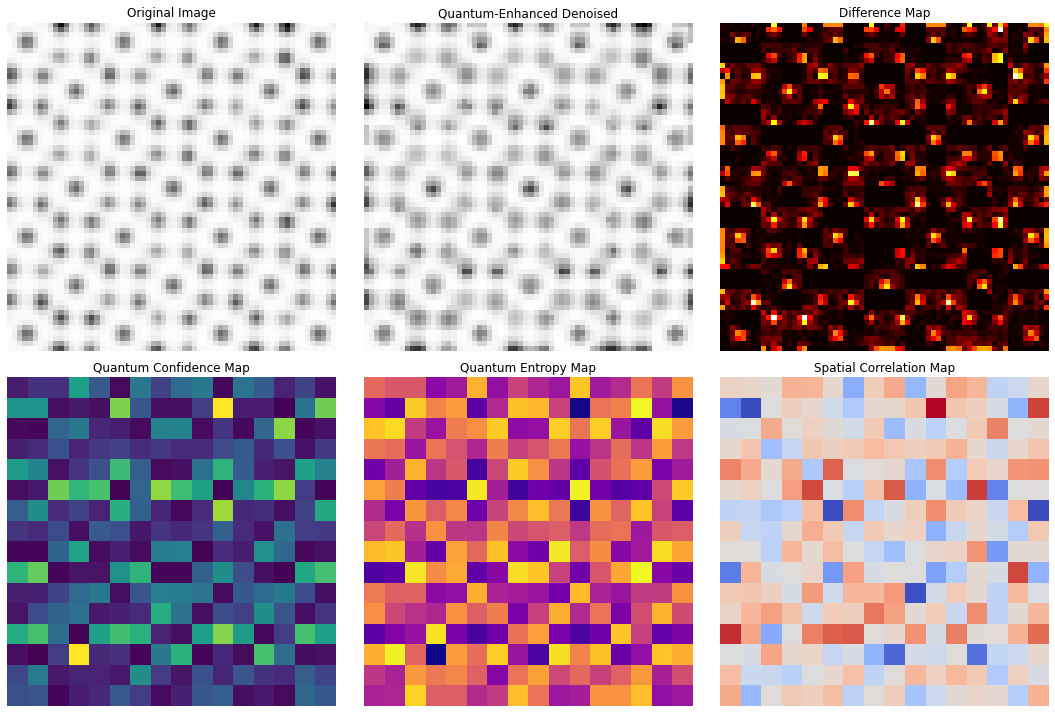


Denoising Performance Metrics:
SNR Improvement: 8.47 dB
Edge Preservation: 0.889
Mean Quantum Confidence: 0.105
Mean Quantum Entropy: 7.088


In [3]:
# trying on the perfect image to see how much this changes; because in theory, should not necessarily change?

# Initialize the quantum denoiser
    denoiser = QuantumMicroscopyDenoiser(patch_size=4, threshold=0.5)
    
    # Process an image
    image_path = 'Images/Ir-KMnO2_62025_noise/resized_bf_image_Ir20pc_1e7dpa.png'
    results = denoiser.process_image(image_path)
    
    # Visualize results
    denoiser.visualize_results(results)

1. Preprocessing image...
   Detected noise level: 0.0024
2. Creating patches...
3. Quantum processing patches...
   Processing patch 0/256
   Processing patch 50/256


/home/iim2209/abtem-env/lib64/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/iim2209/abtem-env/lib64/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


   Processing patch 100/256
   Processing patch 150/256
   Processing patch 200/256
   Processing patch 250/256
4. Decoding quantum features...
5. Applying adaptive classical denoising...


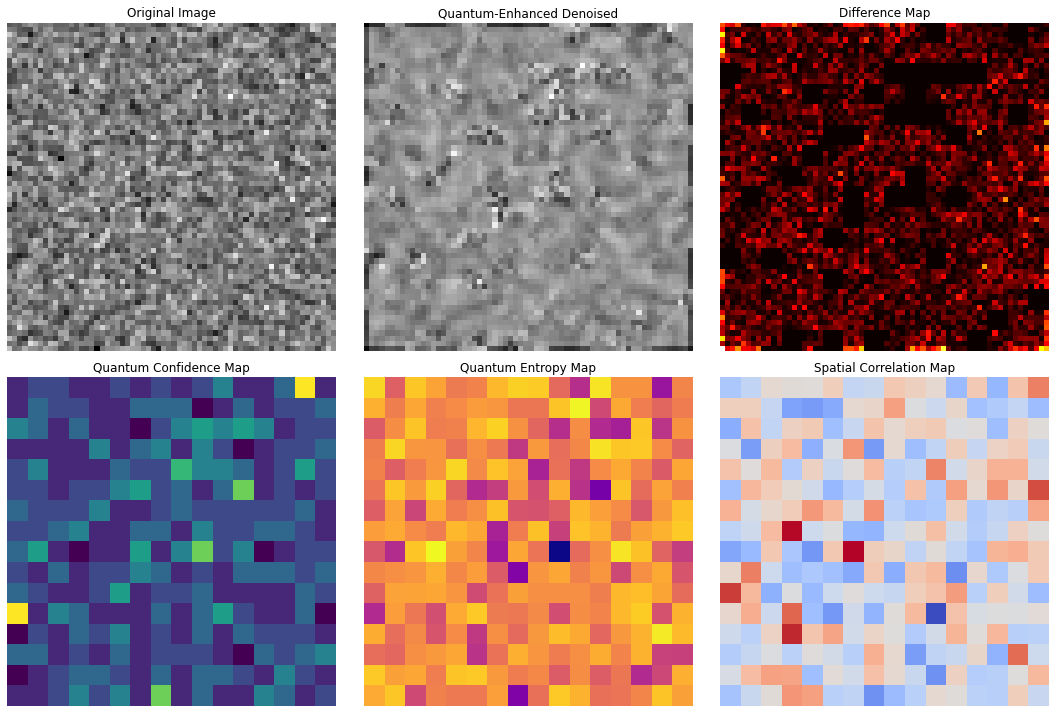


Denoising Performance Metrics:
SNR Improvement: 2.57 dB
Edge Preservation: 0.531
Mean Quantum Confidence: 0.005
Mean Quantum Entropy: 9.632


In [4]:
# trying on the bad image to see how much this changes
# Initialize the quantum denoiser
    denoiser = QuantumMicroscopyDenoiser(patch_size=4, threshold=0.5)
    
    # Process an image
    image_path = 'Images/Ir-KMnO2_62025_noise/resized_bf_image_Ir20pc_1e1dpa.png'
    results = denoiser.process_image(image_path)
    
    # Visualize results
    denoiser.visualize_results(results)

1. Preprocessing image...
   Detected noise level: 0.0023
2. Creating patches...
3. Quantum processing patches...
   Processing patch 0/256
   Processing patch 50/256
   Processing patch 100/256
   Processing patch 150/256
   Processing patch 200/256
   Processing patch 250/256
4. Decoding quantum features...
5. Applying adaptive classical denoising...


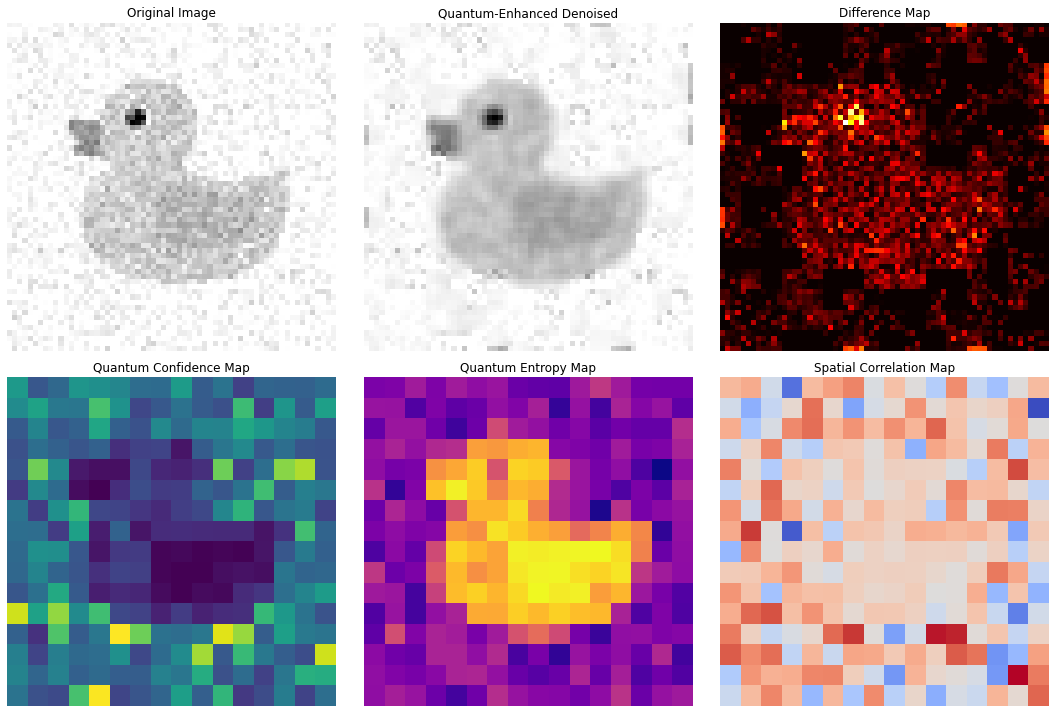


Denoising Performance Metrics:
SNR Improvement: 7.21 dB
Edge Preservation: 0.808
Mean Quantum Confidence: 0.092
Mean Quantum Entropy: 6.308


In [6]:
denoiser = QuantumMicroscopyDenoiser(patch_size=4, threshold=0.5)
    
# Process an image
image_path = 'NoisyDuckSet3/gauss_006_std0.068.png'
results = denoiser.process_image(image_path)
    
# Visualize results
denoiser.visualize_results(results)

1. Preprocessing image...
   Detected noise level: 0.0101
2. Creating patches...
3. Quantum processing patches...
   Processing patch 0/256
   Processing patch 50/256
   Processing patch 100/256
   Processing patch 150/256
   Processing patch 200/256
   Processing patch 250/256
4. Decoding quantum features...
5. Applying adaptive classical denoising...


/home/iim2209/abtem-env/lib64/python3.6/site-packages/scipy/signal/signaltools.py:1475: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/home/iim2209/abtem-env/lib64/python3.6/site-packages/scipy/signal/signaltools.py:1475: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


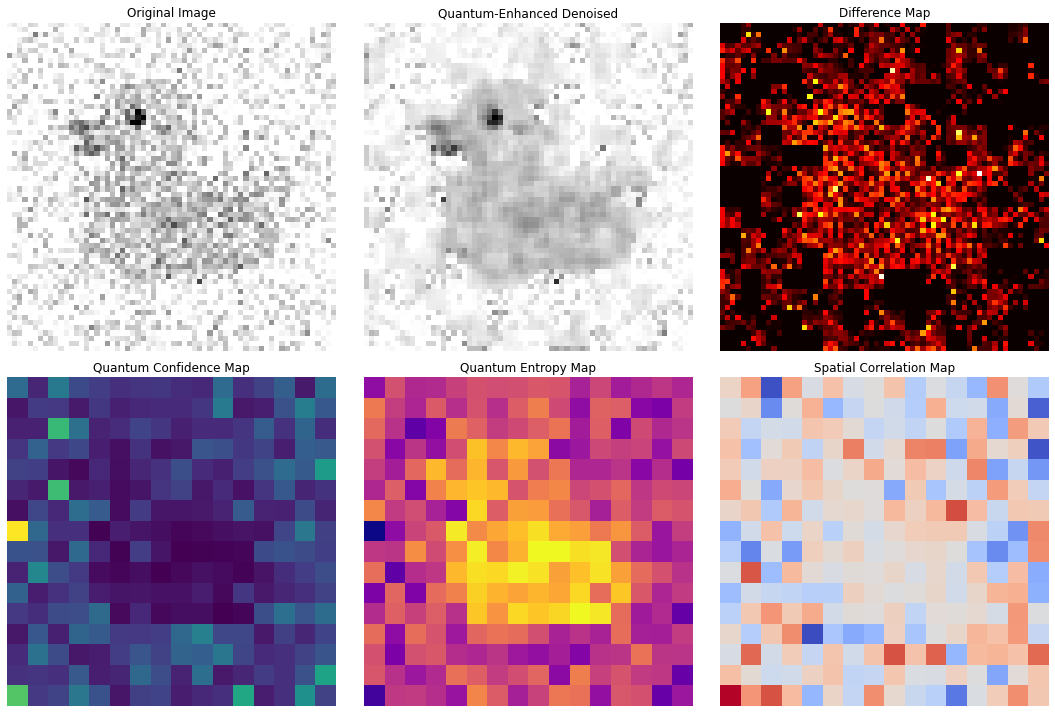


Denoising Performance Metrics:
SNR Improvement: 3.51 dB
Edge Preservation: 0.644
Mean Quantum Confidence: 0.072
Mean Quantum Entropy: 6.864


In [7]:
denoiser = QuantumMicroscopyDenoiser(patch_size=4, threshold=0.5)
    
# Process an image
image_path = 'NoisyDuckSet3/gauss_034_std0.164.png'
results = denoiser.process_image(image_path)
    
# Visualize results
denoiser.visualize_results(results)

Below is the official code developed for QuScope:

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
import os

from scipy.ndimage import gaussian_filter, median_filter, sobel
from scipy.signal import wiener
from sklearn.cluster import KMeans

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, assemble
from qiskit import Aer
from qiskit.circuit.library import MCXGate

class ImageDenoiser:
    def __init__(self, patch_size=4, threshold=0.5):
        self.patch_size = patch_size
        self.threshold = threshold
        self.quantum_features = {}
        self.confidence_map = None
        
    def preprocess_image(self, image_path, size=(64,64)):
        """Enhanced preprocessing with noise characterization"""
        img = Image.open(image_path).convert('L')
        img_resized = img.resize(size)
        img_array = np.array(img_resized) / 255.0
        
        # Estimate noise level
        noise_level = self.estimate_noise_level(img_array)
        return img_array, noise_level
    
    def estimate_noise_level(self, img_array):
        """Estimate noise level using Laplacian variance"""
        laplacian_var = np.var(gaussian_filter(img_array, sigma=1) - img_array)
        return laplacian_var
    
    def create_oracle(self, img_array, threshold=None):
        """Enhanced oracle with adaptive thresholding"""
        if threshold is None:
            threshold = self.threshold
            
        size = img_array.shape[0]
        n_qubits = size * size
        oracle_qc = QuantumCircuit(n_qubits)
        
        # Adaptive threshold based on local statistics
        local_mean = np.mean(img_array)
        local_std = np.std(img_array)
        adaptive_threshold = local_mean + 0.5 * local_std
        
        for i, pixel in enumerate(img_array.flatten()):
            if pixel < adaptive_threshold:
                oracle_qc.x(i)
        
        mcx = MCXGate(n_qubits - 1)
        oracle_qc.append(mcx, list(range(n_qubits)))
        
        return oracle_qc.to_gate(label='Oracle')
    
    def diffusion_operator(self, n_qubits):
        """Diffusion operator for Grover's algorithm"""
        qc = QuantumCircuit(n_qubits)
        
        for qubit in range(n_qubits):
            qc.h(qubit)
        
        for qubit in range(n_qubits):
            qc.x(qubit)
        
        mcx = MCXGate(n_qubits - 1)
        qc.append(mcx, list(range(n_qubits)))
        
        for qubit in range(n_qubits):
            qc.x(qubit)
        
        for qubit in range(n_qubits):
            qc.h(qubit)
        
        return qc.to_gate(label='Diffusion')
    
    def apply_grovers_search(self, qc, oracle, n_iterations=1):
        """Apply Grover's search algorithm"""
        n_qubits = qc.num_qubits
        diffusion = self.diffusion_operator(n_qubits)
        
        for _ in range(n_iterations):
            qc.append(oracle, list(range(n_qubits)))
            qc.append(diffusion, list(range(n_qubits)))
    
    def quantum_segment_patch(self, img_array, n_iterations=1):
        """Enhanced quantum segmentation with feature extraction"""
        size = img_array.shape[0]
        n_qubits = size * size
        
        qr = QuantumRegister(n_qubits, 'q')
        cr = ClassicalRegister(n_qubits, 'c')
        qc = QuantumCircuit(qr, cr)
        
        # Enhanced state preparation with amplitude encoding
        flat_img = img_array.flatten()
        for i, pixel in enumerate(flat_img):
            if pixel > 0:
                # Use RY rotation for amplitude encoding
                qc.ry(2 * np.arccos(np.sqrt(min(pixel, 0.999))), qr[i])
        
        # Apply quantum feature extraction
        oracle = self.create_oracle(img_array)
        self.apply_grovers_search(qc, oracle, n_iterations)
        
        # Add quantum Fourier transform for frequency analysis
        self.apply_qft_analysis(qc, qr)
        
        qc.measure(qr, cr)
        
        # Simulate
        simulator = Aer.get_backend('qasm_simulator')
        compiled = transpile(qc, simulator)
        result = simulator.run(assemble(compiled, shots=1024)).result()
        counts = result.get_counts()
        
        return self.extract_quantum_features(counts, size, img_array)
    
    def apply_qft_analysis(self, qc, qr):
        """Apply simplified QFT for frequency domain analysis"""
        n_qubits = len(qr)
        # Simplified QFT implementation for small patches
        for i in range(min(n_qubits, 4)):  # Limit QFT to prevent circuit depth issues
            qc.h(qr[i])
            for j in range(i+1, min(n_qubits, 4)):
                qc.cp(np.pi/2**(j-i), qr[j], qr[i])
    
    def extract_quantum_features(self, counts, size, original_patch):
        """Extract meaningful features from quantum measurements"""
        features = {}
        
        # 1. Probability distribution analysis
        total_shots = sum(counts.values())
        prob_dist = {k: v/total_shots for k, v in counts.items()}
        
        # 2. Entropy calculation (measure of quantum coherence)
        entropy = -sum(p * np.log2(p + 1e-10) for p in prob_dist.values())
        features['entropy'] = entropy
        
        # 3. Most probable states (potential feature pixels)
        sorted_states = sorted(counts.items(), key=lambda x: x[1], reverse=True)
        features['top_states'] = sorted_states[:5]
        
        # 4. Confidence based on measurement concentration
        max_count = max(counts.values())
        confidence = max_count / total_shots
        features['confidence'] = confidence
        
        # 5. Spatial correlation with original patch
        features['spatial_correlation'] = self.calculate_spatial_correlation(
            sorted_states, size, original_patch
        )
        
        return features
    
    def calculate_spatial_correlation(self, sorted_states, size, original_patch):
        """Calculate spatial correlation between quantum measurements and original patch"""
        correlations = []
        
        for bitstring, count in sorted_states[:3]:  # Top 3 states
            # Convert bitstring to spatial pattern
            pattern = np.zeros((size, size))
            bitstring_clean = bitstring.replace(' ', '')
            
            if len(bitstring_clean) == size * size:
                for i, bit in enumerate(bitstring_clean):
                    if bit == '1':
                        row, col = i // size, i % size
                        pattern[row, col] = 1
                
                # Calculate correlation with original patch
                correlation = np.corrcoef(pattern.flatten(), original_patch.flatten())[0, 1]
                if not np.isnan(correlation):
                    correlations.append(correlation * count)
        
        return np.mean(correlations) if correlations else 0
    
    def decode_quantum_features(self, all_quantum_features, original_shape):
        """Decode quantum features back to spatial domain"""
        h, w = original_shape
        patch_h, patch_w = self.patch_size, self.patch_size
        
        # Initialize decoded features maps
        confidence_map = np.zeros((h, w))
        entropy_map = np.zeros((h, w))
        correlation_map = np.zeros((h, w))
        
        patch_idx = 0
        for i in range(0, h, patch_h):
            for j in range(0, w, patch_w):
                if patch_idx < len(all_quantum_features):
                    features = all_quantum_features[patch_idx]
                    
                    # Map features back to spatial coordinates
                    end_i = min(i + patch_h, h)
                    end_j = min(j + patch_w, w)
                    
                    confidence_map[i:end_i, j:end_j] = features.get('confidence', 0)
                    entropy_map[i:end_i, j:end_j] = features.get('entropy', 0)
                    correlation_map[i:end_i, j:end_j] = features.get('spatial_correlation', 0)
                
                patch_idx += 1
        
        return {
            'confidence': confidence_map,
            'entropy': entropy_map,
            'correlation': correlation_map
        }
    
    def adaptive_classical_denoising(self, img_array, feature_maps):
        """Apply classical denoising guided by quantum features"""
        confidence_map = feature_maps['confidence']
        entropy_map = feature_maps['entropy']
        
        # Create adaptive filter weights based on quantum confidence
        denoised = np.copy(img_array)
        
        # High confidence regions: preserve original
        high_conf_mask = confidence_map > np.percentile(confidence_map, 75)
        
        # Low confidence regions: apply stronger denoising
        low_conf_mask = confidence_map < np.percentile(confidence_map, 25)
        
        # Medium confidence: apply moderate denoising
        med_conf_mask = ~(high_conf_mask | low_conf_mask)
        
        # Apply different denoising strategies
        # Gaussian filter for low confidence (noisy) regions
        denoised_gaussian = gaussian_filter(img_array, sigma=1.5)
        denoised[low_conf_mask] = denoised_gaussian[low_conf_mask]
        
        # Median filter for medium confidence regions
        denoised_median = median_filter(img_array, size=3)
        denoised[med_conf_mask] = 0.7 * denoised_median[med_conf_mask] + 0.3 * img_array[med_conf_mask]
        
        # Wiener filter for edge enhancement where appropriate
        entropy_threshold = np.percentile(entropy_map, 60)
        edge_regions = entropy_map > entropy_threshold
        
        if np.any(edge_regions):
            # Apply edge-preserving filter
            denoised_wiener = wiener(img_array, noise=0.1)
            denoised[edge_regions] = denoised_wiener[edge_regions]
        
        return denoised
    
    def process_image(self, image_path):
        """Complete quantum-classical denoising pipeline"""
        print("1. Preprocessing image...")
        img_array, noise_level = self.preprocess_image(image_path)
        original_shape = img_array.shape
        
        print(f"   Detected noise level: {noise_level:.4f}")
        
        print("2. Creating patches...")
        patches = self.create_patches(img_array)
        
        print("3. Quantum processing patches...")
        all_quantum_features = []
        
        for i, patch in enumerate(patches):
            if i % 50 == 0:
                print(f"   Processing patch {i}/{len(patches)}")
            
            features = self.quantum_segment_patch(patch)
            all_quantum_features.append(features)
        
        print("4. Decoding quantum features...")
        feature_maps = self.decode_quantum_features(all_quantum_features, original_shape)
        
        print("5. Applying adaptive classical denoising...")
        denoised_image = self.adaptive_classical_denoising(img_array, feature_maps)
        
        return {
            'original': img_array,
            'denoised': denoised_image,
            'feature_maps': feature_maps,
            'quantum_features': all_quantum_features
        }
    
    def create_patches(self, img_array):
        """Create overlapping patches for better reconstruction"""
        patches = []
        h, w = img_array.shape
        patch_h, patch_w = self.patch_size, self.patch_size
        
        for i in range(0, h, patch_h):
            for j in range(0, w, patch_w):
                patch = img_array[i:i+patch_h, j:j+patch_w]
                # Pad if necessary
                if patch.shape != (patch_h, patch_w):
                    padded_patch = np.zeros((patch_h, patch_w))
                    padded_patch[:patch.shape[0], :patch.shape[1]] = patch
                    patch = padded_patch
                patches.append(patch)
        
        return patches
    
    def visualize_results(self, results):
        """Visualize the denoising results"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Original and denoised
        axes[0,0].imshow(results['original'], cmap='gray')
        axes[0,0].set_title('Original Image')
        axes[0,0].axis('off')
        
        axes[0,1].imshow(results['denoised'], cmap='gray')
        axes[0,1].set_title('Quantum-Enhanced Denoised')
        axes[0,1].axis('off')
        
        # Difference map
        diff = np.abs(results['denoised'] - results['original'])
        axes[0,2].imshow(diff, cmap='hot')
        axes[0,2].set_title('Difference Map')
        axes[0,2].axis('off')
        
        # Feature maps
        axes[1,0].imshow(results['feature_maps']['confidence'], cmap='viridis')
        axes[1,0].set_title('Quantum Confidence Map')
        axes[1,0].axis('off')
        
        axes[1,1].imshow(results['feature_maps']['entropy'], cmap='plasma')
        axes[1,1].set_title('Quantum Entropy Map')
        axes[1,1].axis('off')
        
        axes[1,2].imshow(results['feature_maps']['correlation'], cmap='coolwarm')
        axes[1,2].set_title('Spatial Correlation Map')
        axes[1,2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Calculate improvement metrics
        self.calculate_metrics(results)
    
    def calculate_metrics(self, results):
        """Calculate denoising performance metrics"""
        original = results['original']
        denoised = results['denoised']
        
        # Signal-to-noise ratio improvement
        original_var = np.var(original)
        noise_var = np.var(original - denoised)
        snr_improvement = 10 * np.log10(original_var / (noise_var + 1e-10))
        
        # Edge preservation metric
        original_edges = np.sqrt(sobel(original, axis=0)**2 + sobel(original, axis=1)**2)
        denoised_edges = np.sqrt(sobel(denoised, axis=0)**2 + sobel(denoised, axis=1)**2)
        edge_preservation = np.corrcoef(original_edges.flatten(), denoised_edges.flatten())[0,1]
        
        print(f"\nDenoising Performance Metrics:")
        print(f"SNR Improvement: {snr_improvement:.2f} dB")
        print(f"Edge Preservation: {edge_preservation:.3f}")
        print(f"Mean Quantum Confidence: {np.mean(results['feature_maps']['confidence']):.3f}")
        print(f"Mean Quantum Entropy: {np.mean(results['feature_maps']['entropy']):.3f}")

# Usage example
if __name__ == "__main__":
    # Initialize the quantum denoiser
    denoiser = ImageDenoiser(patch_size=4, threshold=0.5)
    
    # Process an image
    image_path = 'Images/Ir-KMnO2_62025_noise/resized_bf_image_Ir20pc_1e3dpa.png'
    results = denoiser.process_image(image_path)
    
    # Visualize results
    denoiser.visualize_results(results)